In [31]:
import pandas as pd
data = pd.read_csv("train.csv")
X, y, smiles = data.drop(["Tm","id","SMILES"], axis=1), data["Tm"], data["SMILES"]

In [32]:
from rdkit.Chem import Lipinski, Crippen, rdMolDescriptors
from rdkit import Chem

def extract_features(smiles: str):
    """
    Extracting chemical features using Chem library
    """
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        # Composition & mass
        "ExactMolWt": rdMolDescriptors.CalcExactMolWt(mol),

        # Physicochemical descriptors
        "LogP": Crippen.MolLogP(mol),
        "TPSA": rdMolDescriptors.CalcTPSA(mol),
        "Fraction_CSP3": rdMolDescriptors.CalcFractionCSP3(mol),
        "Formal_Charge": sum(atom.GetFormalCharge() for atom in mol.GetAtoms()),

        # Topology
        "Num_Rings": rdMolDescriptors.CalcNumRings(mol),
        "Num_Aromatic_Rings": rdMolDescriptors.CalcNumAromaticRings(mol),
        "Rotatable_Bonds": Lipinski.NumRotatableBonds(mol),

        # Atomic composition
        "Heavy_Atom_Count": rdMolDescriptors.CalcNumHeavyAtoms(mol),
        "Num_Heteroatoms": rdMolDescriptors.CalcNumHeteroatoms(mol),
        "Num_StereoCenters": rdMolDescriptors.CalcNumAtomStereoCenters(mol),

        # H-bonding / Drug-likeness features
        "HBA": Lipinski.NumHAcceptors(mol),
        "HBD": Lipinski.NumHDonors(mol),
    }

features_list = [extract_features(s) for s in smiles]
df_custom_features = pd.DataFrame([f for f in features_list if f is not None])

In [33]:
from collections import Counter
def element_counts(smiles: str):
    """
    Counting the number of chemical elements
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # List of element symbols in the molecule
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
    return dict(Counter(elements))

counts = []
for s in smiles:
    counts.append(element_counts(s))
    
df_chemical_elements = pd.DataFrame(counts).fillna(0)

In [34]:
df = pd.concat([X, df_custom_features], axis=1)
df = pd.concat([df, df_chemical_elements], axis=1)
df.columns = df.columns.str.replace(r"\s+", "_", regex=True)
df.shape

(2662, 447)

In [35]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(
    df,
    y,
    n_neighbors=5,
    random_state=42
)

mi_series = (
    pd.Series(mi, index=df.columns)
      .sort_values(ascending=False)
)


In [6]:
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
def lgb_kfold_cv(
    X, y,
    params,
    n_splits=10,
    random_state=42
):
    kf = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    fold_mae = []
    best_iters = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(
            objective="mae",
            n_estimators=5000,
            learning_rate=0.03,
            random_state=42,
            device="gpu",          
            gpu_platform_id=0,
            gpu_device_id=0,
            verbosity=-1, 
            **params
        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="mae",
            callbacks=[
                lgb.early_stopping(80),
                lgb.log_evaluation(0)
            ]
        )

        fold_mae.append(model.best_score_["valid_0"]["l1"])
        best_iters.append(model.best_iteration_)

    return {
        "mae_mean": np.mean(fold_mae),
        "mae_std": np.std(fold_mae),
        "best_iter_mean": int(np.mean(best_iters))
    }


In [7]:
param_space = {
    "max_depth": [9, 10, 11],          
    "num_leaves": [27, 31],            
    "min_data_in_leaf": [15, 20],      
    "lambda_l2": [5, 10],              

    # FIXED 
    "subsample": [0.6],
    "colsample_bytree": [0.6],
    "min_gain_to_split": [0.0],
    "max_bin": [255],
}


In [9]:
import itertools
import time

all_params = list(itertools.product(*param_space.values()))
results = []
param_names = list(param_space.keys())

param_grid = all_params
n_total = len(param_grid)

TOP_K = 100
top_features = mi_series.index[:TOP_K]
X = df[top_features]

for i, params_tuple in enumerate(param_grid, start=1):
    t0 = time.time()

    params = dict(zip(param_space.keys(), params_tuple))

    cv_res = lgb_kfold_cv(
        X, y,
        params=params,
        n_splits=10
    )

    iter_time = time.time() - t0

    print(
        f"[{i:02d}/{n_total}] "
        f"MAE={cv_res['mae_mean']:.4f} ± {cv_res['mae_std']:.4f} | "
        f"iter≈{cv_res['best_iter_mean']} | "
        f"time={iter_time:.1f}s"
    )

    results.append({**params, **cv_res})


Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[2536]	valid_0's l1: 31.4801
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[2327]	valid_0's l1: 28.2172
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1821]	valid_0's l1: 31.1979
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[696]	valid_0's l1: 30.6908
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[640]	valid_0's l1: 29.2844
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[502]	valid_0's l1: 29.9156
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[857]	valid_0's l1: 31.4849
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1095]	valid_0's l1: 29.4461
Trai

In [10]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("mae_mean")

results_df.head(10)

,max_depth,num_leaves,min_data_in_leaf,lambda_l2,subsample,colsample_bytree,min_gain_to_split,max_bin,mae_mean,mae_std,best_iter_mean
20,11,31,15,5,0.6,0.6,0.0,255,30.116438,1.970114,1125
9,10,27,15,10,0.6,0.6,0.0,255,30.177252,1.931705,1120
17,11,27,15,10,0.6,0.6,0.0,255,30.220901,1.802834,1129
12,10,31,15,5,0.6,0.6,0.0,255,30.266245,1.918025,925
1,9,27,15,10,0.6,0.6,0.0,255,30.277109,1.961908,1237
0,9,27,15,5,0.6,0.6,0.0,255,30.287672,1.974242,1162
13,10,31,15,10,0.6,0.6,0.0,255,30.290701,1.896168,961
21,11,31,15,10,0.6,0.6,0.0,255,30.335692,1.787464,1011
16,11,27,15,5,0.6,0.6,0.0,255,30.339316,1.855172,1046
4,9,31,15,5,0.6,0.6,0.0,255,30.351219,1.917342,955


In [11]:
results_df["mae_upper"] = results_df["mae_mean"] + results_df["mae_std"]

best_row = results_df.sort_values("mae_upper").iloc[0]
best_row

max_depth              11.000000
num_leaves             27.000000
min_data_in_leaf       15.000000
lambda_l2              10.000000
subsample               0.600000
colsample_bytree        0.600000
min_gain_to_split       0.000000
max_bin               255.000000
mae_mean               30.220901
mae_std                 1.802834
best_iter_mean       1129.000000
mae_upper              32.023736
Name: 17, dtype: float64

In [12]:
results_df.to_csv("lgb_grid_search_results.csv", index=False)

30.73588914648625


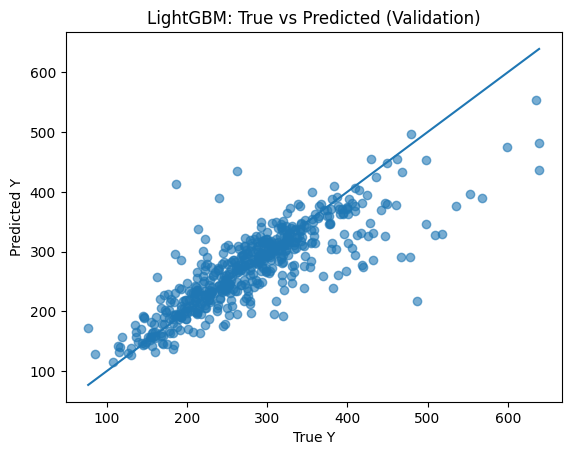

In [36]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

model_val = lgb.LGBMRegressor(
    objective="mae",
    n_estimators=1129,
    learning_rate=0.03,
    random_state=42,
    device="gpu",
    gpu_platform_id=0,
    gpu_device_id=0,
    verbosity=-1,
    max_depth=11,
    num_leaves=27,
    min_data_in_leaf=15,
    lambda_l2=10.0,
    subsample=0.6,
    colsample_bytree=0.6,
    min_gain_to_split=0.0,
    max_bin=255
)

X_train, X_val, y_train, y_val = train_test_split(
    df[mi_series.index[:100]],
    y,
    test_size=0.2,
    random_state=42
)

model_val.fit(X_train, y_train)
y_val_pred = model_val.predict(X_val)

min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
print(mean_absolute_error(y_val, y_val_pred))
plt.figure()
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("LightGBM: True vs Predicted (Validation)")
plt.show()

Final prediction

In [49]:
model_final = lgb.LGBMRegressor(
    objective="mae",
    n_estimators=1129,
    learning_rate=0.03,
    random_state=42,
    device="gpu",
    gpu_platform_id=0,
    gpu_device_id=0,
    verbosity=-1,
    max_depth=11,
    num_leaves=27,
    min_data_in_leaf=15,
    lambda_l2=10.0,
    subsample=0.6,
    colsample_bytree=0.6,
    min_gain_to_split=0.0,
    max_bin=255
)

model_final.fit(X, y)

LGBMRegressor(colsample_bytree=0.6, device='gpu', gpu_device_id=0,
              gpu_platform_id=0, lambda_l2=10.0, learning_rate=0.03,
              max_bin=255, max_depth=11, min_data_in_leaf=15,
              min_gain_to_split=0.0, n_estimators=1129, num_leaves=27,
              objective='mae', random_state=42, subsample=0.6, verbosity=-1)

In [50]:
data = pd.read_csv("test.csv")
X_test, id, smiles = data.drop(["id","SMILES"], axis=1), data["id"], data["SMILES"]

features_list = [extract_features(s) for s in smiles]
df_custom_features = pd.DataFrame([f for f in features_list if f is not None])

counts = []
for s in smiles:
    counts.append(element_counts(s))
    
df_chemical_elements = pd.DataFrame(counts).fillna(0)

df = pd.concat([X_test, df_custom_features], axis=1)
df = pd.concat([df, df_chemical_elements], axis=1)
df.columns = df.columns.str.replace(r"\s+", "_", regex=True)
df = df[top_features]
print( "Same number of samples: ", len(df) == len(id))
df.columns == X.columns

Same number of samples:  True


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [51]:
y_test_pred = model_final.predict(df)
submission = pd.DataFrame({
    "id": id.values,
    "melting_point": y_test_pred
})

In [53]:
submission.to_csv(
    "submission.csv",
    index=False,
    float_format="%.6f"
)
submission.head()

,id,melting_point
0,1022,328.297424
1,1146,325.174389
2,79,216.831958
3,2279,214.325036
4,1342,252.841660
